# LPS and LCS in Swiss-Prot

In [1]:
include("source/io.jl")
include("source/mask.jl")
include("source/palindrome.jl")
include("source/alignment.jl")
include("source/expectation.jl")
using StringAlgorithms: longestcommonsubstring
using ProgressMeter
using Plots
using StatsBase: mean
using Base.Threads: @threads;

SyntaxError: invalid syntax (3362712491.py, line 6)

In [2]:
shuf_sprot = readsequences("data/shuf_sprot.fa")
sprot = readsequences("data/sprot.fa");
masked_sprot = replace.(readsequences("data/masked_sprot.fa"), "X"=>"");

SyntaxError: invalid syntax (996636217.py, line 3)

In [ ]:
print("λ₂ = ")
println(coincidence(join(sprot)))

### Compute LPS and LCS

In [1]:
function llcs(x, y, progressmeter)
    next!(progressmeter)
    length(longestcommonsubstring(x, y)[1])
end
function llps(x, progressmeter)
    next!(progressmeter)
    length(longestpalindromicsubstring(x))
end
function generate_lps(x, resultpath)
    n = length(x)
    results = zeros(Int, n)
    p = Progress(n, 1, resultpath)
    @threads for i=1:n
        results[i] = llps(x[i], p)
    end
    lx = length.(x)
    print("writing LPS to ", resultpath)
    writeframe(resultpath, DataFrame([lx, results], ["length", "lps"]))
end
function generate_lcs(x, y, resultpath)
    @assert length(x) == length(y)
    n = length(x)
    results = zeros(Int, n)
    p = Progress(n, 1, resultpath)
    @threads for i=1:n
        results[i] = llcs(x[i], y[i], p)
    end
    lx = length.(x)
    ly = length.(y)
    print("writing LCS to ", resultpath)
    writeframe(resultpath, DataFrame([lx, ly, results], ["length1", "length2", "lcs"]))
end

SyntaxError: invalid syntax (1480043931.py, line 1)

In [ ]:
resultpaths = [
    "outputs/lcs_sprot_shuf_sprot.txt", 
    "outputs/lps_sprot.txt", 
    "outputs/lps_shuf_sprot.txt", 
    "outputs/lps_hardmasked_sprot.txt"];
generate_lcs(sprot, shuf_sprot, resultpaths[1])
generate_lps(shuf_sprot, resultpaths[3])
generate_lps(sprot, resultpaths[2])
generate_lps(masked_sprot, resultpaths[4]);

## Plot [python]

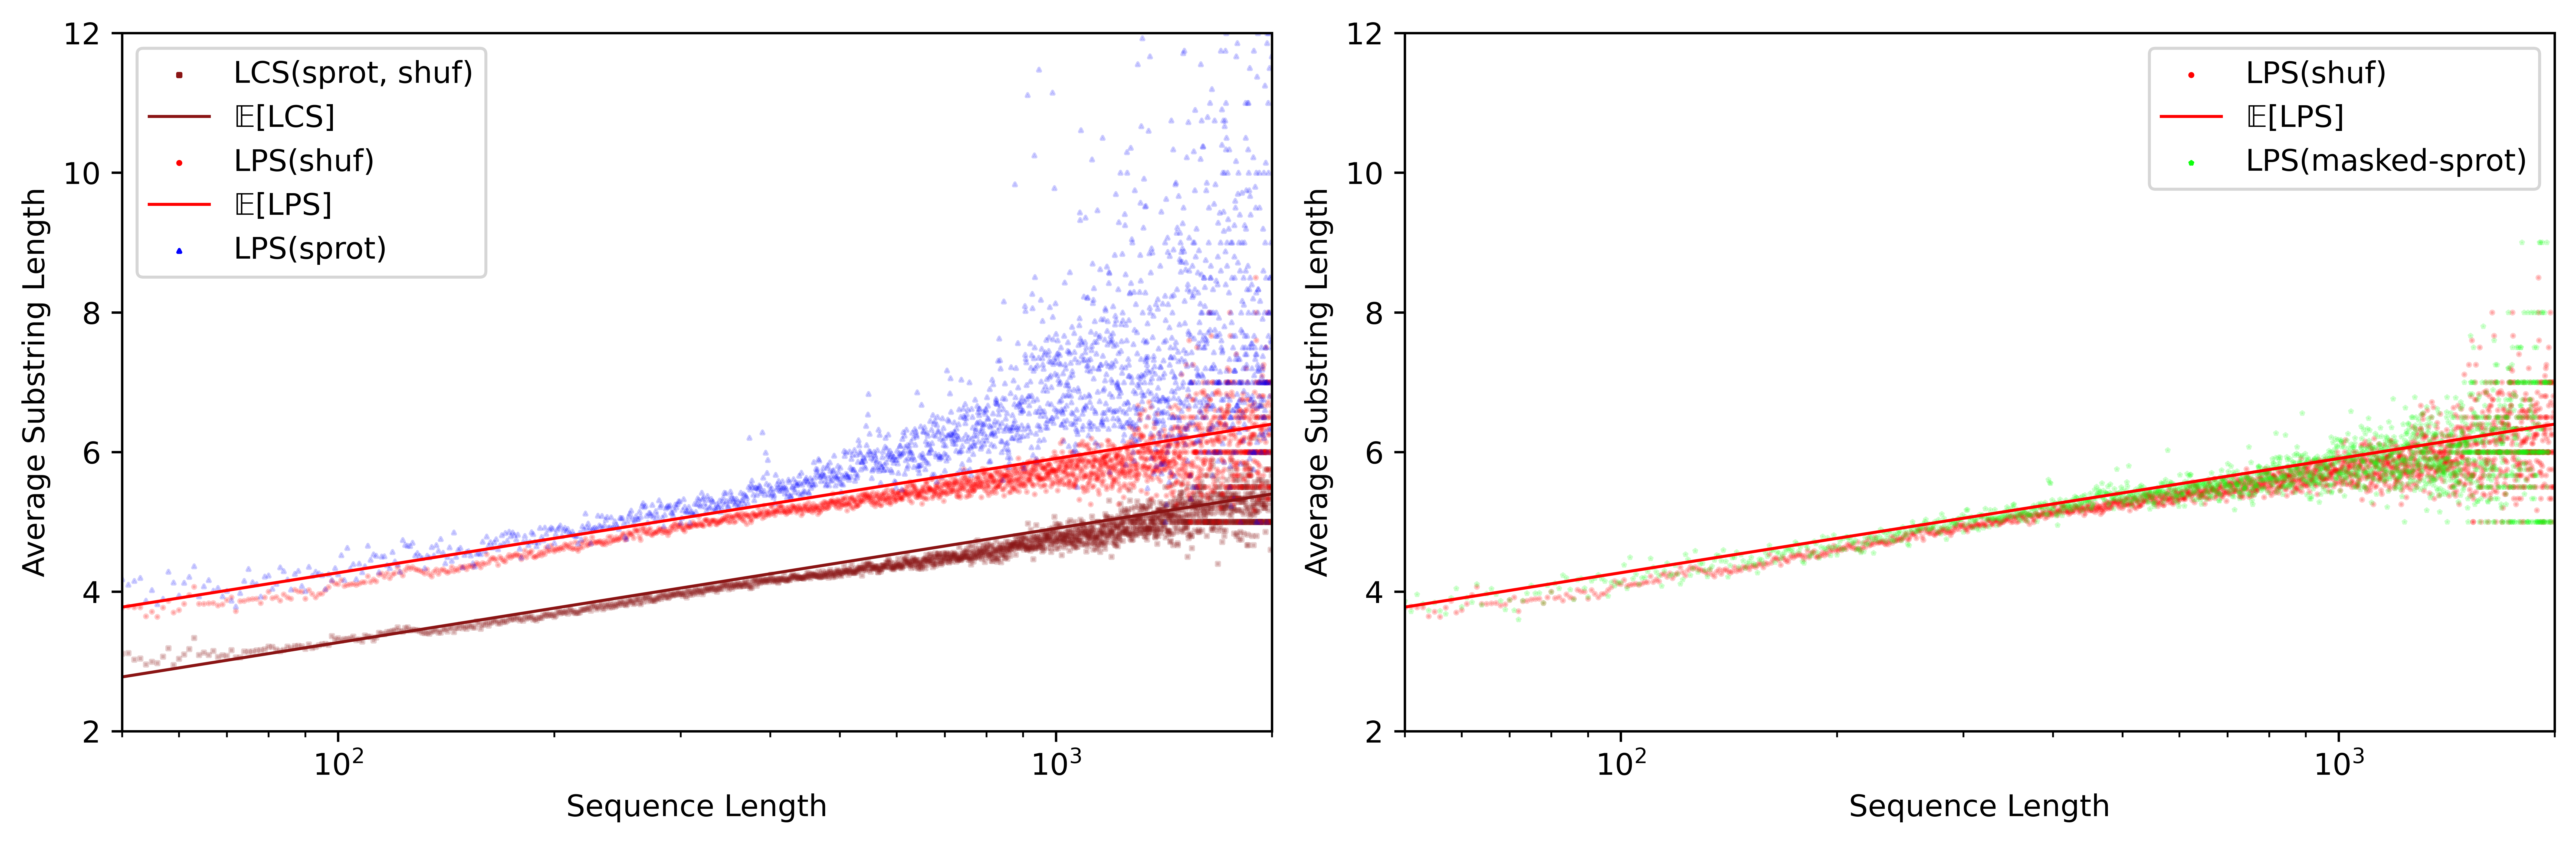

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import statistics as stats
from math import *
cluster = lambda data, parameter, lo, hi : [data[parameter==x] for x in range(lo,hi+1)]
robust_cluster_means = lambda data_clusters : [stats.mean(cluster) if len(cluster)>0 else 0 for cluster in data_clusters]
def scatter_cluster_means(axis, frame, datakey, parakey, lo, hi, color, marker, label):
    clusters = cluster(frame[datakey], frame[parakey], lo, hi)
    x = robust_cluster_means(clusters)
    y = list(range(lo,hi+1))
    axis.scatter(y, x, 1, 
                 color=color, label=label, marker=marker, alpha=0.2)
exp_lcs = lambda n, lambda2: 2*log(n, 1/lambda2)
exp_lps = lambda n, lambda2: exp_lcs(n, lambda2) + 1
def plot_expected_lcs(axis, lambda2, lo, hi, color):
    x = list(range(lo,hi+1))
    axis.plot(x, [exp_lcs(n, lambda2) for n in x], 
              color=color, linewidth=1, label="𝔼[LCS]")
def plot_expected_lps(axis, lambda2, lo, hi, color):
    x = list(range(lo,hi+1))
    axis.plot(x, [exp_lps(n, lambda2) for n in x], 
              color=color, linewidth=1, label="𝔼[LPS]")
def setup_axis(axis):
    axis.set_xlim(50,2000)
    axis.set_xscale("log")
    axis.set_xlabel("Sequence Length")
    axis.set_ylim(2,12)
    axis.set_yscale("linear")
    axis.set_ylabel("Average Substring Length")
    leg = axis.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

resultpaths = ["lcs_sprot_shuf_sprot.txt", 
    "lps_sprot.txt", 
    "lps_shuf_sprot.txt", 
    "lps_hardmasked_sprot.txt"]
lcs_sprot_shuf, lps_sprot, lps_shuf, lps_hardmasked_sprot = [pd.read_csv(x) for x in resultpaths]

# coincidence frequency for Swiss-Prot
lambda2 = 0.05985802744978473

lcsmaroon = "#8a1414"
sprotblue = "#0000ff"
shufred = "#ff0000"
maskgreen = "#0cff0c"

fig, (ax1, ax2) = plt.subplots(1,2,dpi=800,figsize=(12,4))
scatter_cluster_means(ax1, lcs_sprot_shuf, "lcs", "length1", 1, 2000, 
                      lcsmaroon, 's', "LCS(sprot, shuf)")
plot_expected_lcs(ax1, lambda2, 1, 2000, lcsmaroon)
scatter_cluster_means(ax1, lps_shuf, "lps", "length", 1, 2000, 
                      shufred, 'o', "LPS(shuf)")
plot_expected_lps(ax1, lambda2, 1, 2000, shufred)
scatter_cluster_means(ax1, lps_sprot, "lps", "length", 1, 2000, 
                      sprotblue, '^', "LPS(sprot)")
setup_axis(ax1)
scatter_cluster_means(ax2, lps_shuf, "lps", "length", 1, 2000, 
                      shufred, 'o', "LPS(shuf)")
plot_expected_lps(ax2, lambda2, 1, 2000, shufred)
scatter_cluster_means(ax2, lps_hardmasked_sprot, "lps", "length", 1, 2000, 
                      maskgreen, '*', "LPS(masked-sprot)")
setup_axis(ax2)
plt.tight_layout()
plt.savefig("figures/LPSLCS_SwissProt.png")